# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [16]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [3]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [6]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [7]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

In [8]:
pd.DataFrame(
    [
        [word1, word2, glove_wiki_vectors.similarity(word1, word2)]
        for word1, word2 in word_pairs
    ],
    columns=["word1", "word2", "similarity"],
)

,word1,word2,similarity
0,coast,shore,0.700027
1,clothes,closet,0.546276
2,old,new,0.643249
3,smart,intelligent,0.755273
4,dog,cat,0.879807
5,tree,lawyer,0.076719


**ANS:** The similarities do make sense as for example if we look at row 6, we see that tree and lawyer are not related, hence the low similarity score (0.0767); however, dog and cat get a high similarity score since they are both animals (0.8798). We could also argue that clothes and closet could also have a higher similarity score than its current score since clothes are generally in closets. In general, all the rows except the 6th row do have similarities that match the similarity of the words, as opposed to the last one that does not. So I would deem that they make sense.

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

In [9]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [10]:
analogy("man", "doctor", "woman")

man : doctor :: woman : ?


,Analogy word,Score
0,nurse,0.773523
1,physician,0.718943
2,doctors,0.682433
3,patient,0.675068
4,dentist,0.672603
5,pregnant,0.664246
6,medical,0.652045
7,nursing,0.645348
8,mother,0.639333
9,hospital,0.638750


In [11]:
glove_wiki_vectors.similarity("white", "rich")

0.447236

In [12]:
glove_wiki_vectors.similarity("black", "rich")

0.5174519

1. 

In [13]:
print("Similarity between asian and intelligent", glove_wiki_vectors.similarity("asian", "intelligent"))
print("Similarity between caucasian and intelligent", glove_wiki_vectors.similarity("asian", "intelligent"))

analogy("asian", "intelligent", "caucasian")

Similarity between asian and intelligent 0.106114455
Similarity between caucasian and intelligent 0.106114455
asian : intelligent :: caucasian : ?


,Analogy word,Score
0,strong-willed,0.620543
1,perceptive,0.560075
2,resourceful,0.558582
3,hard-working,0.554555
4,studious,0.550979
5,idealistic,0.549289
6,headstrong,0.538079
7,erudite,0.537841
8,thoughtful,0.535560
9,personable,0.533659


In [21]:
# my own defined func
def compare(type1, type2, keyword):
    comp1 = glove_wiki_vectors.similarity(type1, keyword)
    comp2 = glove_wiki_vectors.similarity(type2, keyword)
    print("%s similarity for %s: %s vs %s: %s" % (keyword, type1, comp1, type2, comp2))

In [37]:
compare("african", "american", "poverty")
compare("african", "american", "smart")
compare("female", "male", "smart")
compare("female", "male", "rich")
compare("white", "black", "lawyer")
compare("white", "black", "successful")
compare("man", "woman", "computer")
compare("man", "woman", "dishwasher")

poverty similarity for african: 0.5121759 vs american: 0.32872263
smart similarity for african: 0.18391752 vs american: 0.3189894
smart similarity for female: 0.24493353 vs male: 0.22782151
rich similarity for female: 0.2790344 vs male: 0.28271425
lawyer similarity for white: 0.3763333 vs black: 0.33861735
successful similarity for white: 0.32388 vs black: 0.3704638
computer similarity for man: 0.37083095 vs woman: 0.28278553
dishwasher similarity for man: 0.028758544 vs woman: 0.11522255


In [35]:
analogy("man", "programmer", "woman")

man : programmer :: woman : ?


,Analogy word,Score
0,educator,0.585333
1,programmers,0.573053
2,linguist,0.543201
3,technician,0.537336
4,freelance,0.536212
5,animator,0.533937
6,translator,0.533419
7,software,0.496662
8,psychotherapist,0.495662
9,technologist,0.488051


In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
<br><br>
**ANS:** These embeddings reflected gender stereotypes present in broader society. This could be harmful in the real world if for example there was a model that did a resume screen for potential hires to predict their performance in the company. This model may pick up that the candidate is a female and discredit the possibility of hiring her over a male individual that may have keywords that more closely associate to a greater performance. Later on, If only men are selected for certain roles, then the bias may be reinforced since only men will be allowed to advance.

Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?
<br><br>
**ANS:** Based on my few tested word comparisons, for the most part I don't see any concerning or alarming biases. I can tell this because the similarity scores are all quite similar, meaning that the model isn't biased to one group or another. However for the first 2 comparisons I made, there may be a slight bias since africans have a higher association to "poverty"(0.5122) vs americans (0.32872). However, this may not be a bias since it could just be the statistical analysis that africans do have a higher poverty rate. It still is a good note to keep track of. Also for the comparison with africans' association to "smart" (0.18392) vs americans (0.31898), we can see that americans are more closely associated which is an example of race bias. Lastly for the last one with dishwasher, females did score a higher similarity as compared to male. I do see this as a gender stereotype, which is concerning with the embeddings. There are infinitely more comparisons I could have done, but for the small sample size I tested, it seemed that the majority were unbiased.

In terms of the gender stereotype observed in class with the man and woman to computer programmer, it doesn't seem like this stereotype is observed with GloVe Wikipedia embeddings, as shown by the analogy above with the comparison to programmer. This is good news, although I'm sure there may still be some biases in the embeddings that weren't caught in this short analysis.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

**ANS:** Even though the vocabulary size is very large, it may not contain all words in the English language. There may be words that are very rarely used, or simply words that have been created more recently that aren't up to date with the embedding data. If we tried to get a word vector that's not in the vocabulary, it would give us an error since there isn't a word in it's database for the embeddings.

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [19]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [4]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [6]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [7]:
import spacy

nlp = spacy.load("en_core_web_md")

In [26]:
# lr with BOW representation from lecture 17
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)

pipe.named_steps["countvectorizer"].fit(X_train)
X_test_transformed = pipe.named_steps["countvectorizer"].transform(X_test)
y_test_transformed = pipe.named_steps["countvectorizer"].transform(y_test)
pipe.fit(X_train, y_train);

print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Train accuracy 0.96
Test accuracy 0.82


In [32]:
# classification report for BOW
# FIGURE OUT THIS ERROR
print(
    classification_report(
        y_test_transformed, pipe.predict(X_test_transformed), target_names=["not predicted right", "predicted right"]
    )
)

AttributeError: lower not found

In [23]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])
# chosen liblinear solver since smaller dataset
lgr = LogisticRegression(max_iter=2000, solver="liblinear")
lgr.fit(X_train_embeddings, y_train)

print("Train accuracy {:.2f}".format(lgr.score(X_train_embeddings, y_train)))
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

Train accuracy 0.84
Test accuracy 0.81


In [31]:
# classification report for average embeddings
print(
    classification_report(
        y_test, pipe.predict(X_test_embeddings), target_names=["not predicted right", "predicted right"]
    )
)

AttributeError: 'int' object has no attribute 'lower'

**ANS:** Between the 2 models, The train average is much higher for the BOW model, while the test scores, showing that the average embeddings have less overfitting. It is important to note that the embeddings are both trained on different corpus, which could lead to different results. The model that is more interpretable is ____ TODO

Here, we can see the benefits of transfer learning reducing overfitting, however it does not do much in terms of improving the actual accuracy score. Before when we were using BOW, the train score was way too high, showing that the model was too complex and particular to the train data. With the average embeddings, the transfer learning may have just generalized the results of the scoring, since the train score is less particular to the training data. But I would say that the actual main benefit of transfer learning potentially improving the accuracy is not observed here.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [33]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [34]:
df.shape

(18249, 13)

In [35]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [36]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [37]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [38]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [44]:
df.sort_values(by='Date', ascending=False)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2018-03-25,2.02,13379.77,86.84,5923.16,98.37,7271.40,6881.80,389.60,0.00,organic,2018,RaleighGreensboro
0,2018-03-25,1.34,1774776.77,63905.98,908653.71,843.45,801373.63,774634.09,23833.93,2905.61,conventional,2018,NewYork
0,2018-03-25,1.45,121917.39,1929.39,18391.86,110.05,101486.09,85313.41,16172.68,0.00,organic,2018,Southeast
0,2018-03-25,1.19,450658.34,205952.19,73267.19,4313.11,167125.85,132488.40,31527.74,3109.71,conventional,2018,SouthCarolina
0,2018-03-25,1.40,524265.69,103573.88,149867.07,998.53,269826.21,155866.80,113666.70,292.71,conventional,2018,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2015-01-04,1.34,8764.33,144.47,6921.75,0.00,1698.11,585.96,1112.15,0.00,organic,2015,CincinnatiDayton
51,2015-01-04,1.44,3930.94,358.05,2432.81,0.00,1140.08,444.17,695.91,0.00,organic,2015,Columbus
51,2015-01-04,1.35,9895.96,4634.70,1647.92,0.00,3613.34,3613.34,0.00,0.00,organic,2015,DallasFtWorth
51,2015-01-04,1.42,22480.07,3199.35,6916.72,7.56,12356.44,1076.67,11279.77,0.00,organic,2015,Denver


**ANS:** Since there are multiple regions, we can see from the ordered df above that this means we have different measurements for the same day. For example, on March 25, 2018, there are entries for many different regions such as Raleigh, Greensboro, NewYork, ect... For each of these entries, we can see that the categorical features that have multiple measurements are the type and region in this case.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

ConversionError: Failed to convert value(s) to axis units: array(['conventional', 'conventional', 'conventional', ..., 'organic',
       'organic', 'organic'], dtype=object)

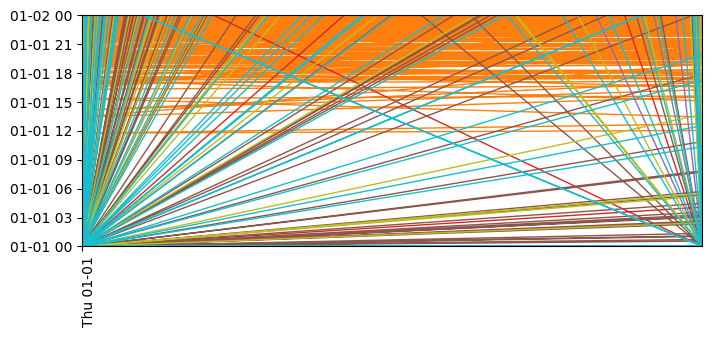

In [46]:
# want to graph the data points on the graph
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(df, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");
plt.title("Number of bike rentals over time for a selected bike station");

**ANS:** 

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [51]:
set(df["region"])

{'Albany',
 'Atlanta',
 'BaltimoreWashington',
 'Boise',
 'Boston',
 'BuffaloRochester',
 'California',
 'Charlotte',
 'Chicago',
 'CincinnatiDayton',
 'Columbus',
 'DallasFtWorth',
 'Denver',
 'Detroit',
 'GrandRapids',
 'GreatLakes',
 'HarrisburgScranton',
 'HartfordSpringfield',
 'Houston',
 'Indianapolis',
 'Jacksonville',
 'LasVegas',
 'LosAngeles',
 'Louisville',
 'MiamiFtLauderdale',
 'Midsouth',
 'Nashville',
 'NewOrleansMobile',
 'NewYork',
 'Northeast',
 'NorthernNewEngland',
 'Orlando',
 'Philadelphia',
 'PhoenixTucson',
 'Pittsburgh',
 'Plains',
 'Portland',
 'RaleighGreensboro',
 'RichmondNorfolk',
 'Roanoke',
 'Sacramento',
 'SanDiego',
 'SanFrancisco',
 'Seattle',
 'SouthCarolina',
 'SouthCentral',
 'Southeast',
 'Spokane',
 'StLouis',
 'Syracuse',
 'Tampa',
 'TotalUS',
 'West',
 'WestTexNewMexico'}

**ANS:** Based on the set of regions as shown above, it does seem like there are some overlapping regions, such as California and San Diego; since San Diego is located within California, this would be an overlapping region. 

<br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [47]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [48]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [49]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [51]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [ ]:
# UHUHUHU HOW??

<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

**ANS:** 
1. We could experience unequally spaced time points in situations such as the occurrences of natural disasters such as volcano eruptions and earthquakes. Since these events happen sporadically, it would occur at irregular times and result in data with unequal spacing.
2. When creating lagged versions of the features, we have to specify the time lag for each feature, which is the number of time units between the current observation and the lagged observation. If the time points are unequally spaced, it can be challenging to determine the appropriate time lag for each feature since the time intervals between observations are irregular. This can result in inaccurate or biased estimates of the relationships between the features and the target variable. On the other hand, encoding the date as one or more features does not rely on time lags and can be used with unequally spaced time points. We can use different date components (e.g., day of the week, month, year) as features to capture temporal patterns in the data. However, this approach may not capture the dynamics and relationships between the features and the target variable over time, which can be captured using lagged versions of features. All in all, creating lagged features would struggle more so with unequally spaced time points. 

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

**ANS:**
1. There would be a problem of considering customers TODO
2. I would say that we don't have enough information to answer, however, based on the common trends with survival analysis data, we could say that customer A would most likely leave first since older customers are usually seen to have longer tenure. It is important to note that this is not absolute and every dataset should be considered and evaluated separately.
3. We can interpret that as the customer never leaving because the longer you stay the least likely you are to leave TODO

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

## BLOG POST

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

The biggest takeaway from this course was understanding the fundamentals of machine learning and how we can solve complex problems and make predictions to make our lives easier. I learned a lot about the different concepts relating to metrics, clustering, feature selection, and more. In addition, one of the main takeaways that I learned was why we split data into traning, validation, and test sets, and how we can observe the quality of a data to determine whether if the data is flawed or not.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

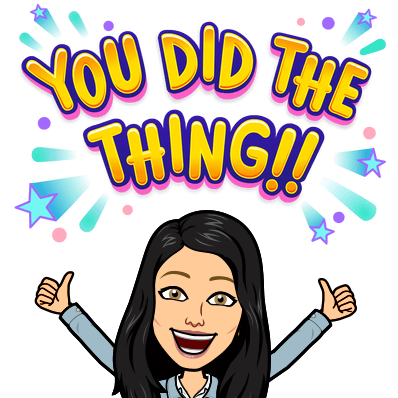

In [33]:
from IPython.display import Image

Image("eva-congrats.png")